In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pylab as plt
from scipy.stats import multivariate_normal as mvn
# initialize K
# import kmeans
from numpy.core.umath_tests import matrix_multiply as mm

# CLUSTER Algorithm

## KMM clusters

In [35]:
import numpy as np
import matplotlib.pylab as plt

# initialize K

# How should we initialize clusters? randomly?
def initialize(X, k):
    mu_i = np.random.randint(0, high=np.shape(X)[0], size=k)
    return X[mu_i, :]

#or with a clever algorithm?
def initialize_kpp(X, k):
    mu = np.zeros([k, np.shape(X)[1]])
    mu_i = np.random.randint(0, high=np.shape(X)[0])
    mu[0, :] = X[mu_i, :]
    for i in np.arange(1, k):
        D2 = np.array([min([np.linalg.norm(x - m)**2 for m in mu]) for x in X])
        probs = D2 / D2.sum()
        cumprobs = probs.cumsum()
        ind = np.where(cumprobs >= np.random.rand())[0][0]
        mu[i, :] = X[ind, :]
    return mu


def assign(X, mu_list):
    distances = np.linalg.norm(X - mu_list[0], axis=1)**2

    for i, mu in enumerate(mu_list[1:]):
        dist = np.linalg.norm(X - mu, axis=1)**2
        distances = np.vstack([distances, dist])
    ind_assignment = np.argmin(distances, axis=0)

    return ind_assignment


def dist_functi(data, indeces, mu, k):
    cost_funct = 0
    for i in range(k):
        distances = np.sum(np.linalg.norm(data[np.where(indeces == i)] - mu[i], axis=1)**2)
        cost_funct += distances
    return cost_funct


def compute_new_mu(data, indeces, K):
    mu = np.zeros([K, np.shape(data)[1]])
    for i in np.arange(K):
        mu[i] = np.mean(data[np.where(indeces == i)], axis=0)
    return mu


def plot_res(data, ind, k):
    plt.figure()
    for i in np.arange(k):
        plt.scatter(data[np.where(ind[:, 0] == i)][:, 0], data[np.where(ind[:, 0] == i)][:, 1])


def run_kmeans(datafile='toydata.txt',  init='k++', k=3, iterate=20):

    data = np.loadtxt(datafile)
    k = 3
    cost = []

    ind_output = np.zeros([np.shape(data)[0], iterate])

    for i in np.arange(iterate):

        if init == 'k++':
            mu = initialize_kpp(data, k)
        else:
            mu = initialize(data, k)

        flag = 0
        cost_internal = []
        while flag == 0:
            ind = assign(data, mu)
            cost_internal.append(dist_functi(data, ind, mu, k))
            new_mu = compute_new_mu(data, ind, k)
            if np.array_equal(new_mu, mu):
                flag = 1
            mu = new_mu
        ind_output[:, i] = ind
        cost.append([cost_internal])
    return cost, ind_output


def run_kmeans_bench(data,  init='k++', k=3, iterate=20):

    k = 3

    ind_output = np.zeros([np.shape(data)[0], iterate])
    for i in np.arange(iterate):

        if init == 'k++':
            mu = initialize_kpp(data, k)
        else:
            mu = initialize(data, k)
        flag = 0
        while flag == 0:
            ind = assign(data, mu)
            new_mu = compute_new_mu(data, ind, k)
            if np.array_equal(new_mu, mu):
                flag = 1
            mu = new_mu
        ind_output[:, i] = ind
    return ind_output



Load toy data

In [5]:
data = np.loadtxt('toydata.txt')


In [25]:
mu

array([[ 0.472, -0.579],
       [ 2.407,  2.649],
       [ 6.354, -3.684]])

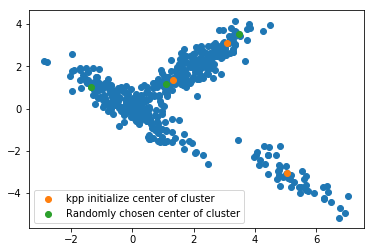

In [29]:
plt.scatter(data[:,0],data[:,1])
mu = initialize_kpp(data, k)
plt.scatter(mu[:,0],mu[:,1],label='kpp initialize center of cluster')
mu = initialize(data, k)
plt.scatter(mu[:,0],mu[:,1],label='Randomly chosen center of cluster')
plt.legend(loc=0)

In [31]:
data = np.loadtxt('toydata.txt')
k = 3
mu = initialize_kpp(data, k)
flag = 0
cost = []
while flag == 0:
    ind = assign(data, mu)
    cost.append(dist_functi(data, ind, mu, k))
    new_mu = compute_new_mu(data, ind, k)
    if np.array_equal(new_mu, mu):
        flag = 1
    mu = new_mu

print('n interations', len(cost))

('n interations', 7)


Now we can look at the clusters we found

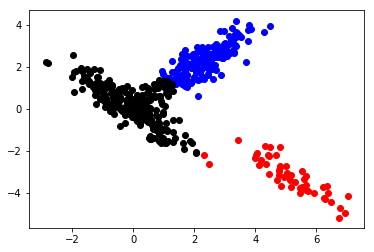

In [21]:
plt.scatter(data[np.where(ind==0),0],data[np.where(ind==0),1],color = 'red')
plt.scatter(data[np.where(ind==1),0],data[np.where(ind==1),1],color = 'blue')
plt.scatter(data[np.where(ind==2),0],data[np.where(ind==2),1],color = 'k')

With random initialization sometimes it does not converge
Do a plot of a live search

They look reasonable

In [47]:
out = run_kmeans_bench(data,  init='k++', k=3, iterate=20)
cost, out = run_kmeans(init='k++', k=3, iterate=20)


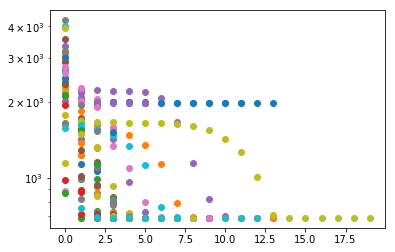

In [73]:
[plt.semilogy(cost[i][0],'o') for i in np.arange(0,len(cost))];
cost, out = run_kmeans(init='random', k=3, iterate=20)
[plt.semilogy(cost[i][0],'o') for i in np.arange(0,len(cost))];


## Gaussian Mixtures

In [74]:
def initialize(X, k):
    pi = np.random.rand(k)
    pi /= np.sum(pi)
    mu = kmeans.initialize_kpp(X, k)
    sigmas = np.array([np.eye(2)] * k)
    return pi, mu, sigmas


def plot_models(xs, pis1, mus1, sigmas1):
    intervals = 101
    ys = np.linspace(-8, 8, intervals)
    X, Y = np.meshgrid(ys, ys)
    _ys = np.vstack([X.ravel(), Y.ravel()]).T
    ind = np.zeros([np.shape(xs)[0], 3])
    z = np.zeros(len(_ys))
    for i, (pi, mu, sigma) in enumerate(zip(pis1, mus1, sigmas1)):
        z += pi * mvn(mu, sigma).pdf(_ys)
        ind[:, i] = pi * mvn(mu, sigma).pdf(xs)

    indeces = np.argmax(ind, axis=1)
    z = z.reshape((intervals, intervals))

    # find indeces to make plot

    ax = plt.subplot(111)
    plt.scatter(mus1[:, 0], mus1[:, 1], alpha=1., c='r', marker='d', s=80)

    plt.scatter(xs[np.where(indeces == 0), 0], xs[np.where(indeces == 0), 1], alpha=0.5, c='b')
    plt.scatter(xs[np.where(indeces == 1), 0], xs[np.where(indeces == 1), 1], alpha=0.5, c='r')
    plt.scatter(xs[np.where(indeces == 2), 0], xs[np.where(indeces == 2), 1], alpha=0.5, c='k')

    plt.contour(X, Y, z, N=3)
    plt.axis([-6, 8, -6, 6])
    ax.axes.set_aspect('equal')
    plt.tight_layout()
    return 0


def MLE_gaussian_mix(data, weights, means, sigmas, tol=0.01, max_iter=100):

    n, p = data.shape
    k = len(weights)

    ll_old = 0
    for i in range(max_iter):

        like_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = weights[j] * mvn(means[j], sigmas[j]).pdf(data)
        ws /= ws.sum(0)

        # M-step
        weights = ws.sum(axis=1)
        weights /= n

        means = np.dot(ws, data)
        # vectorize this in python is damn hard you can do the trick with transpose
        # means /= ws.sum(1)[:, None]
        means = (means.T / ws.sum(1)).T

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = data - means[j, :]
            sigmas[j] = (ws[j, :, None, None] * mm(ys[:, :, None], ys[:, None, :])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:, None, None]

        # compute the  likelihoood anc compare
        like_new = 0
        for pi, mu, sigma in zip(weights, means, sigmas):
            like_new += pi * mvn(mu, sigma).pdf(data)
        like_new = np.log(like_new).sum()

        if np.abs(like_new - ll_old) < tol:
            break
        ll_old = like_new

    return like_new, weights, means, sigmas


---


In [ ]:
data = np.loadtxt('3Ddata.txt')

## PCA

In [9]:

def plot_3d(x, ind):
    from mpl_toolkits.mplot3d import Axes3D
    colors = {1: 'g', 2: 'y', 3: 'b', 4: 'r'}

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in np.unique(ind):
        ax.scatter(x[np.where(ind == i)][:, 0], x[np.where(ind == i)][:, 1],
                   x[np.where(ind == i)][:, 2], c=colors[i], alpha=0.8)
    return 0


def plot_2d(x, ind):
    colors = {1: 'g', 2: 'y', 3: 'b', 4: 'r'}
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in np.unique(ind):
        ax.scatter(x[np.where(ind == i)][:, 0], x[np.where(ind == i)][:, 1], c=colors[i], alpha=0.8)
    return 0


def plot_1d(x, ind):
    colors = {1: 'g', 2: 'y', 3: 'b', 4: 'r'}
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in np.unique(ind):
        ax.plot(x[np.where(ind == i)][:, 0], c=colors[i], alpha=0.8)
    return 0

# pca starts here.

def pca(x):
    # center
    x -= np.mean(x, axis=0)
    # compute conv
    sigma = np.dot(x.T, x) / x.shape[0]
    # eigenproblem
    values, vectors = np.linalg.eigh(sigma)
    # sort them
    idx = values.argsort()[::-1]
    # eigenValues = values[idx]
    eigenVectors = vectors[:, idx]

    # project into eigenvector and return
    return np.dot(x, eigenVectors[:, :2])


In [12]:
x = data[:, 0:3]
res = pca(x);

## ISOMAP

In [13]:
def distance_matrix(data):
    '''
    tested
    '''
    distances = np.zeros([data.shape[0], data.shape[0]])
    for (i, pointi) in enumerate(data):
        for (j, pointj) in enumerate(data):
            distances[i, j] = np.linalg.norm(pointi - pointj)
    return distances


def set_K_neighboorg(distances, k=10):
    '''
    tested
    '''
    output = np.ones_like(distances)
    # set not connected to inf
    output *= np.inf
    np.fill_diagonal(output, 0)

    for i in range(distances.shape[0]):
        closest = distances[:, i].argsort()[0:k]
        # print i, closest
        output[i, closest] = distances[i, closest]
        # output[closest, i] = distances[closest, i]
    return output


# apply Floyd algotrithm

def shortest_path(distances):
    output = distances.copy()
    # for i in range(output.shape[0]):
    #     output = np.minimum(output, np.add.outer(output[:, i], output[i, :]))

    # for k in range(output.shape[0]):
    #     for j in range(output.shape[0]):
    #         for j in range(output.shape[0]):
    #             output[i,j] = min(output[i,j], output[i,k] + output[k,j])
    for k in xrange(output.shape[0]):
        output = minimum(output, output[newaxis, k, :] + output[:, k, newaxis])

    # for k in xrange(output.shape[0]):
    #     for i in xrange(output.shape[0]):
    #         output[i,:] = minimum(output[i,:], output[i,k] + output[k,:])

    return output


# Below all give the same mds tested for debugging



# ========= I TRIED DIFFERENT MDS CAUSE IT DID NOT SEEM TO WORK AT FIRST
# do MDS on this
def mds_run(d, dimensions=2):
    '''
    not fully tested yet
    '''
    # create G_tilde from dist

    (n, n) = d.shape
    # create G_tilde − 1/2 P*D*P
    E = (-0.5 * d**2)

    # Use mat to get column and row means to act as column and row means.
    Er = np.mat(np.mean(E, 1))
    Es = np.mat(np.mean(E, 0))

    F = array(E - transpose(Er) - Es + mean(E))

    [U, S, V] = np.linalg.svd(F)

    # create data given the gram matrix using preposition 2

    Y = U * np.sqrt(S)

    return (Y[:, 0:dimensions], S)


# do MDS on this
def mds_run_2(data, dimensions=2):

    # create G_tilde from data

    data -= np.mean(data, axis=0)
    F = np.dot(data, data.T)
    [U, S, V] = np.linalg.svd(F)

    # create data given the gram matrix using preposition 2

    Y = U * np.sqrt(S)

    return (Y[:, 0:dimensions], S)


def cmdscale(D):

    # Number of points
    n = len(D)

    # Centering matrix
    H = np.eye(n) - np.ones((n, n)) / n

    # YY^T
    B = -H.dot(D**2).dot(H) / 2

    # Diagonalize
    evals, evecs = np.linalg.eigh(B)

    # Sort by eigenvalue in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Compute the coordinates using positive-eigenvalued components only
    w, = np.where(evals > 0)
    L = np.diag(np.sqrt(evals[w]))
    V = evecs[:, w]
    Y = V.dot(L)

    return Y, evals


def isomap(data, dim=2, k=10):
    # compute l2 distances among points
    dist = distance_matrix(data)
    # convert into a graph with k-neighbourhs
    #  deltaij = -inf if not connected
    dist_k = set_K_neighboorg(dist, k=k)
    # compute shortest path on the graph
    geodesic_distance = shortest_path(dist_k)
    # apply mds to it
    y, s = mds_run(geodesic_distance, dimensions=dim)
    return y

## Laplacian

In [14]:

def distance_matrix(data):
    '''
    tested
    '''
    distances = np.zeros([data.shape[0], data.shape[0]])
    for (i, pointi) in enumerate(data):
        for (j, pointj) in enumerate(data):
            distances[i, j] = np.linalg.norm(pointi - pointj)
    return distances


def laplacian_eig(data, dim=2, k=10, sigma=0.5):

    dist = distance_matrix(data)

# build the graph
    graph = np.zeros(dist.shape)
    L2_dist = dist.copy()
# set k neigh connected disconnect the others
    for i in np.arange(dist.shape[0]):
        dist[i, i] = np.inf
        for j in np.arange(k):
            idx = dist[i].argmin()
            graph[i, idx] = 1.0
            graph[idx, i] = graph[i, idx]
            dist[i, idx] = np.inf
    print np.sum(dist[:,0]!=np.inf)
    # Step 2: Choosing the weights using the heat input

    nz = np.nonzero(graph)
    graph[nz] *= np.exp(-L2_dist[nz]**2 / sigma)

    # Laplacian matrix solve Lf=l Df
    weight = np.diag(graph.sum(1))
    # build laplacian l
    laplacian = weight - graph
    laplacian[np.isinf(laplacian)] = 0
    laplacian[np.isnan(laplacian)] = 0

    # Generalized Eigenvalue Decomposition
    # generalized problem
    val, vec = scipy.linalg.eig(laplacian, weight)
    index = np.real(val).argsort()
    # leave eigenvector 0 alone and return the firs d after that
    return vec[:, index[1:dim + 1]]


## ILE

In [15]:
import scipy
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

data = np.loadtxt('3Ddata.txt')
x = data[:, 0:3]

#! /usr/bin/env python
# -*- coding: utf-8 -*-


def distance_matrix(data):
    '''
    tested
    '''
    distances = np.zeros([data.shape[0], data.shape[0]])
    for (i, pointi) in enumerate(data):
        for (j, pointj) in enumerate(data):
            distances[i, j] = np.linalg.norm(pointi - pointj)
    return distances


def lle(data, dim=2, k=10):
    # compute L2 distance
    dist = distance_matrix(data)

    rn = xrange(dist.shape[0])
    dist[rn, rn] = np.inf

    neigh = dist.argsort(1)

    # STEP2: Solve for Reconstruction Weights
    # using a linear system is faster than inverting the matrix
    tol = 1e-3

    W = np.zeros((data.shape[0], k))
    for i in xrange(W.shape[0]):
        z = data[neigh[i, :k], :] - data[i]
        C = np.dot(z, z.T)
        # C_inv  = np.linalg.inv(C)
        # print np.sum(C_inv,axis=1)/np.sum(C_inv)
        # just a bit of tolerance in case it is singular
        C = C + np.eye(k) * tol * np.trace(C)
        W[i, :] = scipy.linalg.solve(C, np.ones((k, 1))).T
        W[i, :] /= W[i, :].sum()


    # Compute Embedding from Eigenvects of Cost Matrix M = (1 - W).T (1 - W)

    M = np.eye(data.shape[0])
    for i in xrange(M.shape[0]):
        w = W[i, :]
        j = neigh[i, :k]
        M[i, j] = M[i, j] - w
        M[j, i] = M[j, i] - w
        for l in xrange(w.shape[0]):
            M[j[l], j] = M[j[l], j] + w[l] * w

    # Calculation of Embedding
    val, vec = scipy.linalg.eig(M)
    index = np.real(val).argsort()
    index = index[::-1]

    return vec[:, index[-(dim + 1):-1]] * np.sqrt(data.shape[0])

# VIOLA JONES FACE RECOGNITION

# Gaussian Processes